### MAST30034: Applied Data Science Project 1
---
# Preprocessing Part 2: Aggregating Data by MMWR Week
#### Xavier Travers (1178369)

Aggregate all the data by MMWR week (defined [here](https://ndc.services.cdc.gov/wp-content/uploads/MMWR_Week_overview.pdf)).
This means counting trips to and from each of the boroughs per month.
This is done for each of the taxi types.

In [1]:
# imports used throughout this notebook
from pyspark.sql import DataFrame
from pyspark.sql import functions as F
import os
import sys
import re
from itertools import chain

# add homemade helpers
sys.path.insert(1, '../../scripts')
import helpers.plot_helpers as ph

# path where the data files are stored
DATA_PATH = '../../data'

In [2]:
from pyspark.sql import SparkSession

# Create a spark session (which will run spark jobs)
spark = (
    SparkSession.builder.appName('MAST30034 XT Project 1')
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config('spark.sql.repl.eagerEval.enabled', True) 
    .config('spark.sql.parquet.cacheMetadata', 'true')
    .config("spark.executor.memory", "2g")
    .config("spark.driver.memory", "4g")
    .getOrCreate()
)

22/08/21 09:03:13 WARN Utils: Your hostname, Polaris resolves to a loopback address: 127.0.1.1; using 172.18.201.145 instead (on interface eth0)
22/08/21 09:03:13 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/08/21 09:03:14 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/08/21 09:03:15 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
22/08/21 09:03:15 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


In [3]:
# read in the pickup data
tlc_pu_df = spark.read.parquet(f'{DATA_PATH}/curated/tlc/aggregated/yellow/by_pu')
tlc_pu_df.limit(5)

week_year,week_month,week_ending,week_index,pu_borough,population,num_trips,num_pc_trips,num_p100k_trips,avg_trip_distance
2020,4,2020-05-02,18,Manhattan,1687834.0,55248,0.032733076831015374,3273.3076831015374,2.8488097306689624
2020,5,2020-05-30,22,Queens,2395791.0,4660,0.001945077846940739,194.5077846940739,9.020862660944168
2020,4,2020-05-02,18,Staten Island,495522.0,35,7.063258543515727E-5,7.063258543515727,23.470000000000002
2020,5,2020-05-23,21,Staten Island,495522.0,89,1.796085743922570...,17.960857439225705,24.68977528089888
2020,4,2020-04-04,14,Brooklyn,2727393.0,1556,5.705081739228634E-4,57.05081739228633,5.651150385604107


In [4]:
# convert the dataset into a pandas dataframe
tlc_pu_df = tlc_pu_df.toPandas()

### Trip Distances

In [5]:
# simple summary statistics (mean and variance)
print(f'''AVERAGE TRIP DISTANCES
MEAN = {tlc_pu_df['avg_trip_distance'].mean()}
VARIANCE = {tlc_pu_df['avg_trip_distance'].var()}''')

AVERAGE TRIP DISTANCES
MEAN = 10.036121221217421
VARIANCE = 58.753211898560046


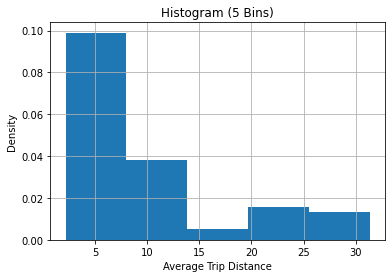

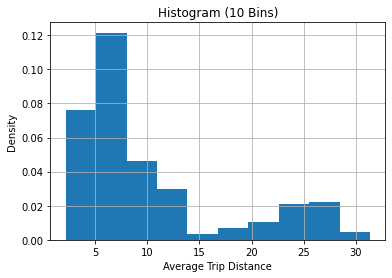

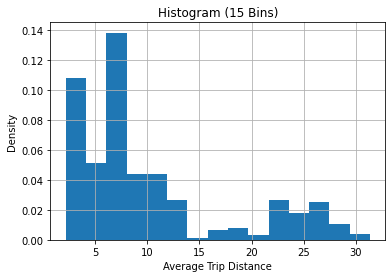

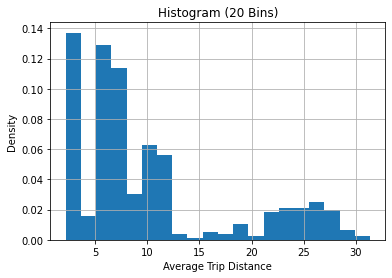

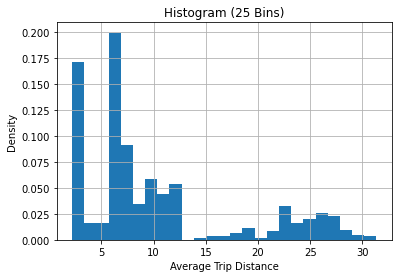

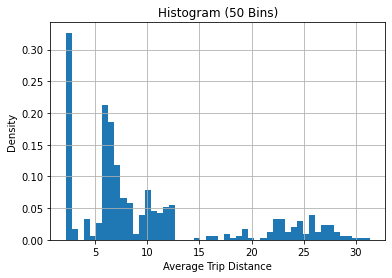

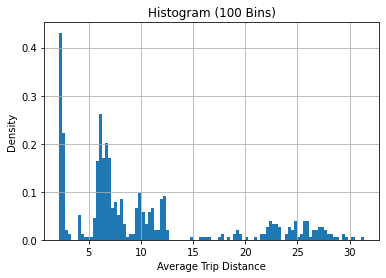

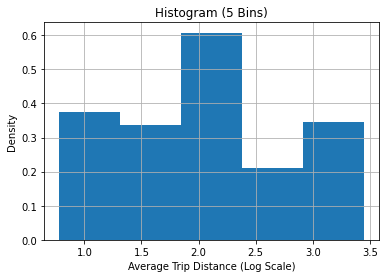

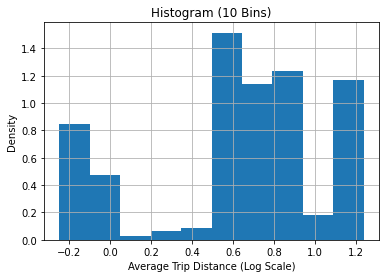

/home/digitaldata/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


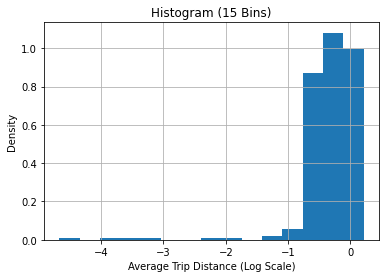

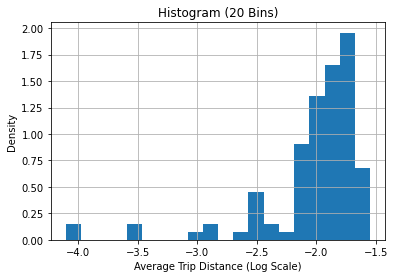

/home/digitaldata/.local/lib/python3.8/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


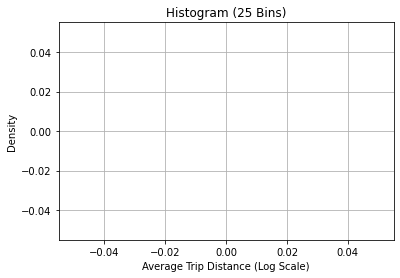

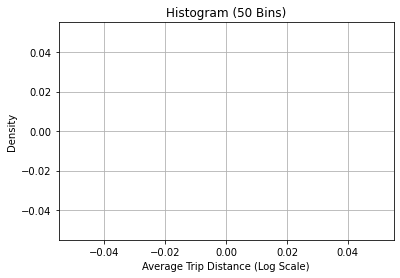

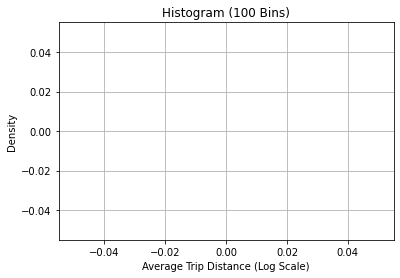

In [6]:
# plot the histogram of trip distances with different bin counts
for logx in [False, True]:
    for bins in [5, 10, 15, 20, 25, 50, 100]:
        ph.histogram(tlc_pu_df, 'avg_trip_distance', 
            'Average Trip Distance', bins, logx)